In [4]:
from  google.colab import drive  
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/econ4130

import pickle
def psave(dataframe, fname):
    with open('{}.pkl'.format(fname),'wb') as pickle_file:
        pickle.dump(dataframe,pickle_file)
        
def pload(fname):
  
  with open('{}.pkl'.format(fname),'rb') as pickle_file:
      dataframe=pickle.load(pickle_file)
      return dataframe



Mounted at /content/drive
/content/drive/My Drive/econ4130


In [5]:
### save and load data using pickle
import pickle
def psave(dataframe, fname):
    with open('{}.pkl'.format(fname),'wb') as pickle_file:
        pickle.dump(dataframe,pickle_file)
        
def pload(fname):
  
  with open('{}.pkl'.format(fname),'rb') as pickle_file:
      dataframe=pickle.load(pickle_file)
      return dataframe

In [2]:
!pip install h5py
from keras.layers import Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error
from keras.layers.convolutional import Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit

In [6]:

Y_trainT=pload('Y_trainT')
Y_testT=pload('Y_testT')
Y_name=['3M','2Y','5Y','10Y','30Y']
X_selected=pload('X_selected2_3')
X_testO=pload('X_testO')

In [ ]:
dfs_TrainT={}
dfs_TestT={}
for i in range(5):
  step=int(np.array(X_selected[i][0]).shape[1]/3)
  split=[ii*step for ii in range(1,3)]
  dfs_TrainT[i] = np.split(X_selected[i][0], split, axis=1)
  dfs_TestT[i]=np.split(X_selected[i][1], split, axis=1)

In [ ]:
def stack(day,dfs):
  l=len(dfs[0])
  output=[[ dfs[i][index] for i in range(day-1,-1,-1)]for index in range(l)]

  return output


In [ ]:
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
def gridsearch(dfs_Trains,Y_train,n_input,d,trainmodel,split=3):
  gen=product(*d.values())
  gen2=product(*d.values())
  print('number of combination:',len(list(gen2)))
  tscv=TimeSeriesSplit(n_splits=split)
  best_para=()
  best_model=keras.Model()
  lowest_score=1000
  index=0
  input=np.array(stack(n_input,dfs_Trains))
  for paras in gen:
    print(paras)
    mseT=[]
    for train_index, test_index in tscv.split(input):
      x_train, x_test = input[train_index], input[test_index]
      y_train, y_test = Y_train[train_index], Y_train[test_index]
      score,model=trainmodel(x_train,y_train,x_test,y_test,paras,n_input)
      mseT.append(score)
      if sum(mseT)/split>lowest_score:
        break
    ave_score=sum(mseT) / len(mseT)
    print('ave_score:',ave_score)
    if ave_score<lowest_score:
      lowest_score=ave_score
      best_para=paras
      best_model=model
    print(index,'done')
    index+=1
  output={}
  for x,y in zip(d.keys(),best_para):
    output[x]=y
  return output,best_model,best_para

In [ ]:
def LSTMM(x_train1,y_train1,x_test1,y_test1,paras,n_input,earlystop=False):
  lstm1=paras[0]
  lstm2=paras[1]
  dense=paras[2]
  epoch=paras[3]
  inputs=Input(shape=(n_input,len(x_train1[0][0])))

  x=tf.keras.layers.LSTM(lstm1 ,activation='relu',return_sequences=True)(inputs)
  x=tf.keras.layers.LSTM(lstm2,activation='relu')(x)
  x=tf.keras.layers.Dense(dense, activation="relu")(x)
  output=tf.keras.layers.Dense(1,activation='relu')(x)
  model=keras.Model(inputs=inputs, outputs=output, name="LSTM_model")
  model.compile(loss='mean_squared_error',
              optimizer='adam')
  if earlystop==True:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=int(epoch*0.4),verbose=0)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=0, save_best_only=True)
# fit model
    model.fit(x_train1, y_train1,
            epochs=epoch,
            verbose=0,callbacks=[callback,mc])
    model = load_model('best_model.h5')
  else:
    model.fit(x_train1, y_train1,
            epochs=epoch,
            verbose=0)
  score=model.evaluate(x_test1,y_test1)
  return score,model



3M

In [ ]:
#3M
ot={}
bm={}
bp={}
for i in [0]:
  d={'lstm1':[32,64,128,256],'lstm2':[32,64,128,256],'dense':[256,128,64,32],'epoch':[100,300,500]}
  n_input=3
  ot[i],bm[i],bp[i]=gridsearch(dfs_TrainT[i],Y_trainT[i],n_input,d,LSTMM,split=3)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.0018
ave_score: 0.019476416520774364
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 3ms/step - loss: 12.6587
ave_score: 12.658720016479492
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 3ms/step - loss: 0.1211
ave_score: 0.12112010270357132
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.1222
ave_score: 0.1222073882818222
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 2ms/step - loss: 12.6587
ave_score: 12.658720016479492
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 1ms/step - loss: 12.6587
ave_score: 12.658720016479492
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 2ms/step - loss: 12.6579
ave_score: 12.657882690429688
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.0810
ave_score: 0.

In [ ]:
print(ot)

{0: {'lstm1': 32, 'lstm2': 32, 'dense': 256, 'epoch': 100}}


In [ ]:
error0=bm[0].evaluate(np.array(stack(n_input,dfs_TestT[0])),Y_testT[0])
print(error0)

36/36 [==============================] - 0s 2ms/step - loss: 0.0033


0.003253217553719878

Text(0.5, 1.0, '3M')

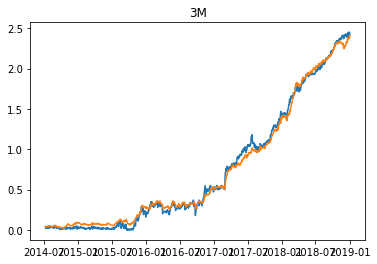

In [ ]:
y=Y_testT[0]

y_p=bm[0].predict(np.array(stack(3,dfs_TestT[0])))
plt.plot(X_testO.index,y)
plt.plot(X_testO.index,y_p)
plt.title('3M')
psave(y_p,'lstmselected_m3')

2Y

In [ ]:
ot={}
bm={}
bp={}
for i in [1]:
  d={'lstm1':[32,64,128,256],'lstm2':[32,64,128,256],'dense':[256,128,64,32],'epoch':[100,300,500]}
  n_input=3
  ot[i],bm[i],bp[i]=gridsearch(dfs_TrainT[i],Y_trainT[i],n_input,d,LSTMM,split=3)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.0023
ave_score: 0.028063746557260554
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 2ms/step - loss: 12.5948
ave_score: 12.594797134399414
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 2ms/step - loss: 0.1984
ave_score: 0.19837704300880432
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 2ms/step - loss: 12.5939
ave_score: 12.593859672546387
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 2ms/step - loss: 12.5948
ave_score: 12.594797134399414
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 2ms/step - loss: 0.0049
ave_score: 0.021949118468910456
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 2ms/step - loss: 12.5943
ave_score: 12.594283103942871
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.0801
ave_score: 

In [ ]:
print(ot)

{1: {'lstm1': 32, 'lstm2': 128, 'dense': 128, 'epoch': 500}}


In [ ]:
error1=bm[1].evaluate(np.array(stack(n_input,dfs_TestT[1])),Y_testT[1])
print(error1)

36/36 [==============================] - 0s 2ms/step - loss: 0.0087


0.008657806552946568

In [ ]:
y_predict_1=bm[1].predict(np.array(stack(n_input,dfs_TestT[1])))

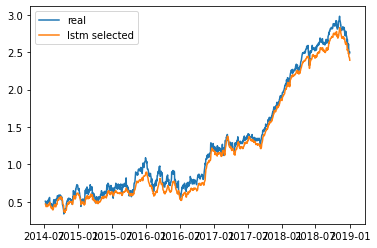

In [ ]:
plt.plot(X_test0.index,Y_testT[1],label='real')
plt.plot(X_test0.index,y_predict_1,label='lstm selected')
plt.legend()
plt.show()
psave(y_predict_1,'lstmselected_y1')

5Y

In [ ]:
ot={}
bm={}
bp={}
for i in [2]:
  d={'lstm1':[32,64,128,256],'lstm2':[32,64,128,256],'dense':[256,128,64,32],'epoch':[100,300,500]}
  n_input=3
  ot[i],bm[i],bp[i]=gridsearch(dfs_TrainT[i],Y_trainT[i],n_input,d,LSTMM,split=3)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 2ms/step - loss: 1.3479
ave_score: 6.533528923988342
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.0211
ave_score: 4.756560895591974
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 2ms/step - loss: 1.3479
ave_score: 0.5585869823892912
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 2ms/step - loss: 4.0379
ave_score: 2.060818124562502
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.0125
ave_score: 0.0644353184228142
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 2ms/step - loss: 0.1902
ave_score: 0.1352967843413353
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 2ms/step - loss: 4.0379
ave_score: 2.040190525352955
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 2ms/step - loss: 14.2107
ave_score: 14.210654258

In [ ]:
print(ot)

{2: {'lstm1': 64, 'lstm2': 64, 'dense': 32, 'epoch': 100}}


In [ ]:
error2=bm[2].evaluate(np.array(stack(n_input,dfs_TestT[2])),Y_testT[2])
print(error2)

36/36 [==============================] - 0s 2ms/step - loss: 0.0770


0.07695072889328003

In [ ]:
y_predict_2=model.predict(np.array(stack(n_input,dfs_TestT[2])))

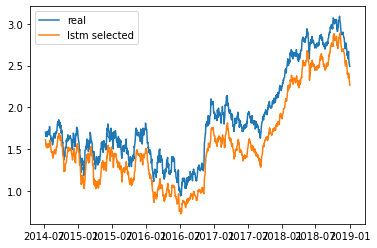

In [ ]:
plt.plot(X_test0.index,Y_testT[2],label='real')
plt.plot(X_test0.index,y_predict_2,label='lstm selected')
plt.legend()
plt.show()
psave(y_predict_2,'lstmselected_y2')

10Y

In [ ]:
ot={}
bm={}
bp={}
for i in [3]:
  d={'lstm1':[32,64,128,256],'lstm2':[32,64,128,256],'dense':[256,128,64,32],'epoch':[100,300,500]}
  n_input=3
  ot[i],bm[i],bp[i]=gridsearch(dfs_TrainT[i],Y_trainT[i],n_input,d,LSTMM,split=3)
  print(ot)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.0151
ave_score: 0.03436154220253229
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 2ms/step - loss: 4.9997
ave_score: 1.6872280941655238
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 2ms/step - loss: 10.3207
ave_score: 5.173652099445462
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 2ms/step - loss: 17.3912
ave_score: 17.391206741333008
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 2ms/step - loss: 17.3912
ave_score: 17.391206741333008
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 2ms/step - loss: 0.0146
ave_score: 0.019444794083635013
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.0686
ave_score: 0.06856495141983032
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.0853
ave_score: 0.0

In [ ]:
error3=bm[3].evaluate(np.array(stack(3,dfs_TestT[3])),Y_testT[3])
print(error3)

36/36 [==============================] - 0s 3ms/step - loss: 0.0165


0.016486620530486107

Text(0.5, 1.0, '10Y')

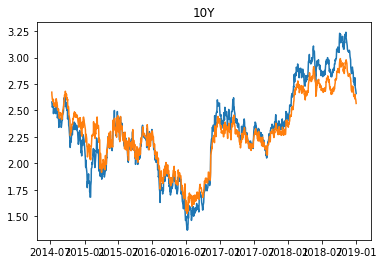

In [ ]:
y=Y_testT[3]

y_p=bm[3].predict(np.array(stack(3,dfs_TestT[3])))
plt.plot(X_testO.index,y)
plt.plot(X_testO.index,y_p)
plt.title('10Y')

In [ ]:
psave(y_p,'lstmselected_y10')

30Y

In [ ]:
ot={}
bm={}
bp={}
for i in [4]:
  d={'lstm1':[32,64,128,256],'lstm2':[32,64,128,256],'dense':[256,128,64,32],'epoch':[100,300,500]}
  n_input=3
  ot[i],bm[i],bp[i]=gridsearch(dfs_TrainT[i],Y_trainT[i],n_input,d,LSTMM,split=3)
  print(ot)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.0094
ave_score: 0.12018164309362571
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 2ms/step - loss: 20.5337
ave_score: 20.533702850341797
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 2ms/step - loss: 20.5336
ave_score: 20.533645629882812
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.0129
ave_score: 0.06591251275191705
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 2ms/step - loss: 10.6803
ave_score: 3.59255699471881
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 2ms/step - loss: 10.6803
ave_score: 3.595551227529844
5 done
(32, 32, 64, 100)
21/21 [==============================] - 1s 2ms/step - loss: 20.5337
ave_score: 20.533695220947266
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.2151
ave_score: 0.215

In [ ]:
error4=bm[4].evaluate(np.array(stack(3,dfs_TestT[4])),Y_testT[4])
print(error4)

36/36 [==============================] - 0s 2ms/step - loss: 0.0087


0.008716096170246601

Text(0.5, 1.0, '30Y')

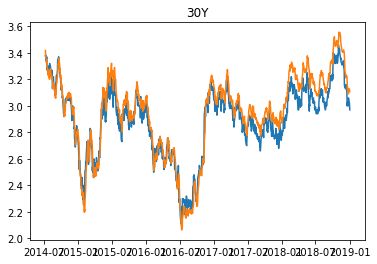

In [ ]:
y=Y_testT[4]

y_p=bm[4].predict(np.array(stack(3,dfs_TestT[4])))
plt.plot(X_testO.index,y)
plt.plot(X_testO.index,y_p)
plt.title('30Y')

In [ ]:
psave(y_p,'lstmselected_y30')

Summary

In [ ]:
error4=0.008716096170246601
error3=0.016486620530486107
error2=0.07695072889328003
error1=0.008657806552946568
error0=0.003253217553719878


In [ ]:
e=[error0,error1,error2,error3,error4]

In [ ]:
psave(e,'LSTMFSERROR')

Graphs

In [ ]:
Y_testT=pload('Y_testT')
X_testO=pload('X_testO')
Y_name=['3M','2Y','5Y','10Y','30Y']

In [ ]:
y_pred={}
y_pred[0]=pload('LSTMM3M')
y_pred[1]=pload('LSTMM2Y')
y_pred[2]=pload('LSTMM5Y')
y_pred[3]=pload('LSTMM10Y')
y_pred[4]=pload('LSTMM30Y')

In [ ]:
y_pred_s={}
y_pred_s[0]=pload('lstmselected_m3')
y_pred_s[1]=pload('lstmselected_y1')
y_pred_s[2]=pload('lstmselected_y2')
y_pred_s[3]=pload('lstmselected_y10')
y_pred_s[4]=pload('lstmselected_y30')

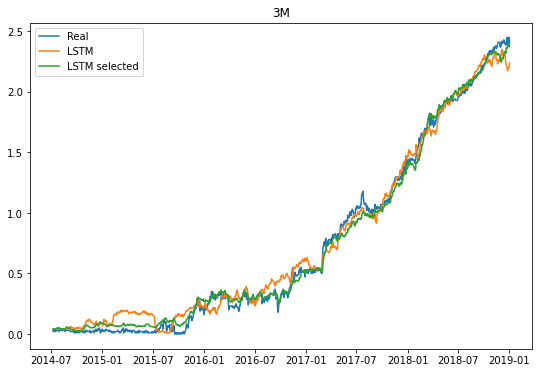

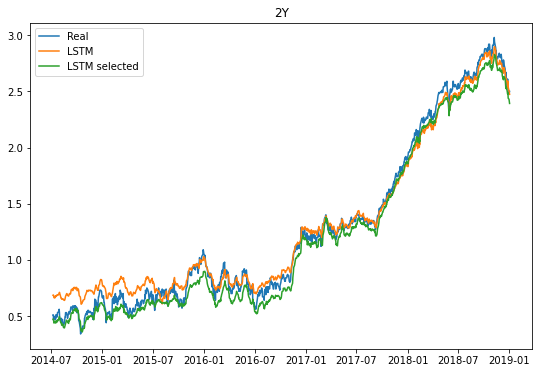

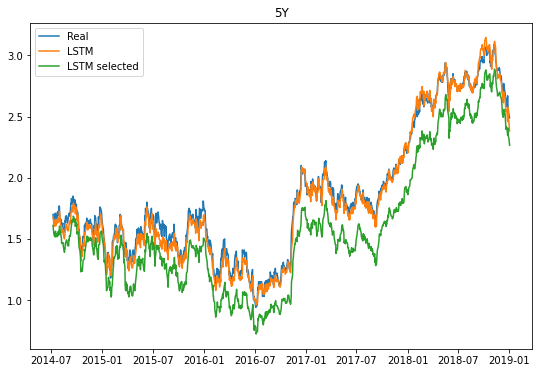

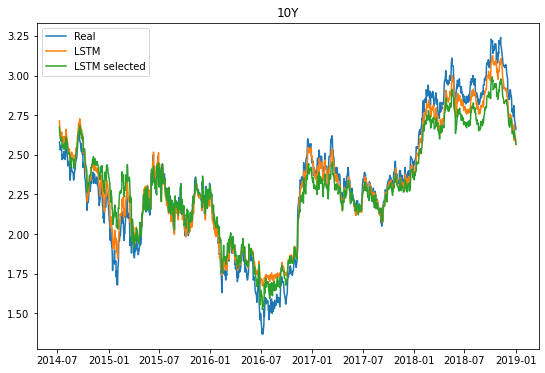

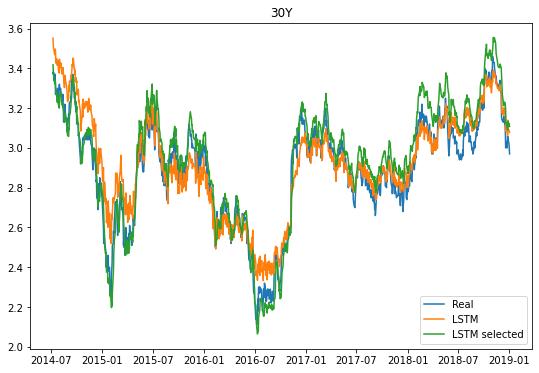

In [ ]:

for i in range(5):

  fig= plt.figure(figsize=[9,6])
  plt.plot(X_testO.index,Y_testT[i],label='Real')
  plt.plot(X_testO.index,y_pred[i],label='LSTM')
  plt.plot(X_testO.index,y_pred_s[i],label='LSTM selected')
  plt.title(Y_name[i])
  plt.legend()
  plt.show()
